# 1.0 Data preparation

In [85]:
from google.colab import drive
import pandas as pd
import ast
import numpy as np

import logging
logging.basicConfig(level=logging.ERROR)  # Show only errors

drive.mount('/content/drive')
drive_path = 'drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Datasets from streaming platforms**

Link: https://www.kaggle.com/victorsoeiro  
Link: https://www.kaggle.com/dgoenrique

In [86]:
amazon_titles = pd.read_csv(drive_path + 'data/amazon/titles.csv')
amazon_credits = pd.read_csv(drive_path + 'data/amazon/credits.csv')
chrunchyroll_titles = pd.read_csv(drive_path + 'data/chrunchyroll/titles.csv')
chrunchyroll_credits = pd.read_csv(drive_path + 'data/chrunchyroll/credits.csv')
darkmatter_titles = pd.read_csv(drive_path + 'data/darkmatter/titles.csv')
darkmatter_credits = pd.read_csv(drive_path + 'data/darkmatter/credits.csv')
disney_titles = pd.read_csv(drive_path + 'data/disney/titles.csv')
disney_credits = pd.read_csv(drive_path + 'data/disney/credits.csv')
hbo_titles = pd.read_csv(drive_path + 'data/hbo/titles.csv')
hbo_credits = pd.read_csv(drive_path + 'data/hbo/credits.csv')
hulu_titles = pd.read_csv(drive_path + 'data/hulu/titles.csv')
hulu_credits = pd.read_csv(drive_path + 'data/hulu/credits.csv')
netflix_titles = pd.read_csv(drive_path + 'data/netflix/titles.csv')
netflix_credits = pd.read_csv(drive_path + 'data/netflix/credits.csv')
paramount_titles = pd.read_csv(drive_path + 'data/paramount/titles.csv')
paramount_credits = pd.read_csv(drive_path + 'data/paramount/credits.csv')
rakutenviki_titles = pd.read_csv(drive_path + 'data/rakutenviki/titles.csv')
rakutenviki_credits = pd.read_csv(drive_path + 'data/rakutenviki/credits.csv')
apple_titles = pd.read_csv(drive_path + 'data/apple/titles.csv')
apple_credits = pd.read_csv(drive_path + 'data/apple/credits.csv')

In [87]:
def merge(titles, credits, platform):
    # Extract actors and directors from credits, ensuring their names are strings
    actors = credits.loc[credits['role'] == 'ACTOR'].copy()
    actors['name'] = actors['name'].astype(str)

    directors = credits.loc[credits['role'] == 'DIRECTOR'].copy()
    directors['name'] = directors['name'].astype(str)

    # Merge titles with actors and directors, and create lists of names grouped by movie ID
    merged_data_actors = pd.merge(titles, actors, on='id', how='left')
    actors_list = merged_data_actors.groupby('id')['name'].apply(lambda x: ', '.join(x.dropna())).reset_index()

    merged_data_directors = pd.merge(titles, directors, on='id', how='left')
    directors_list = merged_data_directors.groupby('id')['name'].apply(lambda x: ', '.join(x.dropna())).reset_index()

    # Combine the data with actor and director lists, renaming columns for clarity
    combined = pd.merge(titles, actors_list, on='id', how='left')
    combined.rename(columns={'name': 'actors'}, inplace=True)

    combined = pd.merge(combined, directors_list, on='id', how='left')
    combined.rename(columns={'name': 'directors'}, inplace=True)

    # Process genres data to convert from list format to a comma-separated string
    combined['genres'] = combined['genres'].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x
    )

    # Add the platform as a new column
    combined['platform'] = platform

    return combined

# Merge datasets for each platform
amazon = merge(amazon_titles, amazon_credits, "amazon")
chrunchyroll = merge(chrunchyroll_titles, chrunchyroll_credits, "chrunchyroll")
darkmatter = merge(darkmatter_titles, darkmatter_credits, "darkmatter")
disney = merge(disney_titles, disney_credits, "disney")
hbo = merge(hbo_titles, hbo_credits, "hbo")
hulu = merge(hulu_titles, hulu_credits, "hulu")
netflix = merge(netflix_titles, netflix_credits, "netflix")
paramount = merge(paramount_titles, paramount_credits, "paramount")
rakutenviki = merge(rakutenviki_titles, rakutenviki_credits, "rakutenviki")
apple = merge(apple_titles, apple_credits, "apple")

# Concatenate all platform-specific datasets into a single DataFrame
all_datasets = pd.concat([
    amazon,
    chrunchyroll,
    darkmatter,
    disney,
    hbo,
    hulu,
    netflix,
    paramount,
    rakutenviki,
    apple
], ignore_index=True)

# Clean up the data: replace empty strings with NaN, drop rows with missing key information, remove duplicates
all_datasets.replace("", np.nan, inplace=True)
all_datasets = all_datasets.dropna(subset=['description'])
all_datasets = all_datasets.dropna(subset=['directors'])
all_datasets = all_datasets.dropna(subset=['actors'])
all_datasets = all_datasets.dropna(subset=['genres'])
all_datasets = all_datasets.drop_duplicates(subset='title')

# Filter out TV shows and remove unnecessary columns
all_datasets.drop(all_datasets[all_datasets['type'] == 'SHOW'].index, inplace=True)
all_datasets.drop('seasons', axis=1, inplace=True)

# Convert 'release_year' to an integer type and reset index
all_datasets['release_year'] = all_datasets['release_year'].astype(int)

all_datasets = all_datasets.reset_index(drop=True)


# 2.0 Data Visualization and Analysis

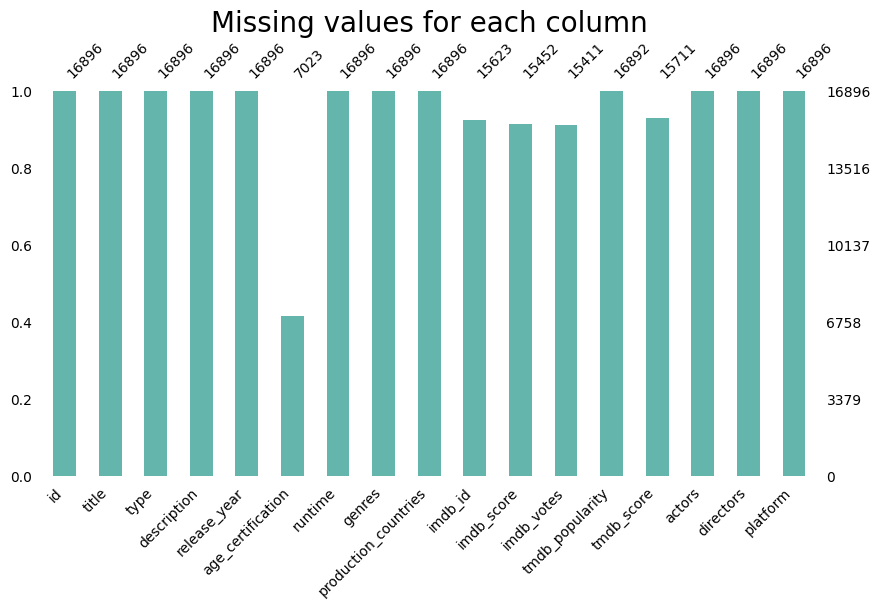

In [88]:
import missingno
import matplotlib.pyplot as plt

missingno.bar(all_datasets,fontsize=10,figsize=(10,5),color='#64b6ac')
plt.title('Missing values for each column',fontsize=20);

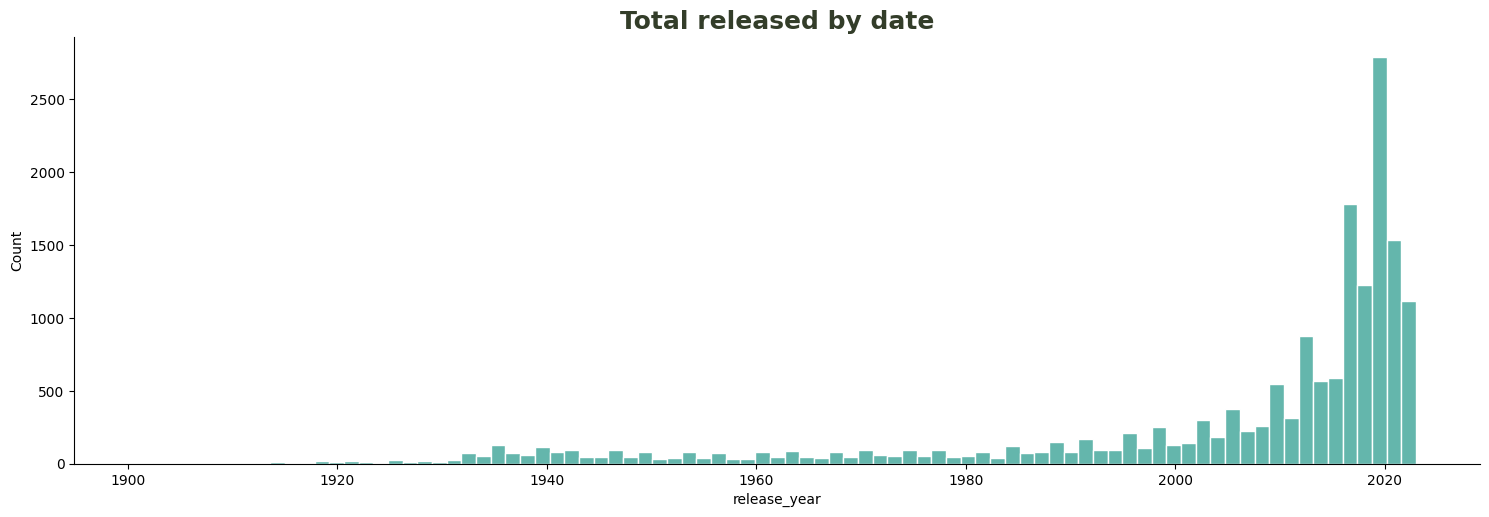

In [89]:
import seaborn as sns

sns.displot(data=all_datasets, x='release_year', facecolor='#64b6ac', edgecolor='#ffffff', aspect=3)
plt.title('Total released by date', fontsize=18, weight=600, color='#333d29');

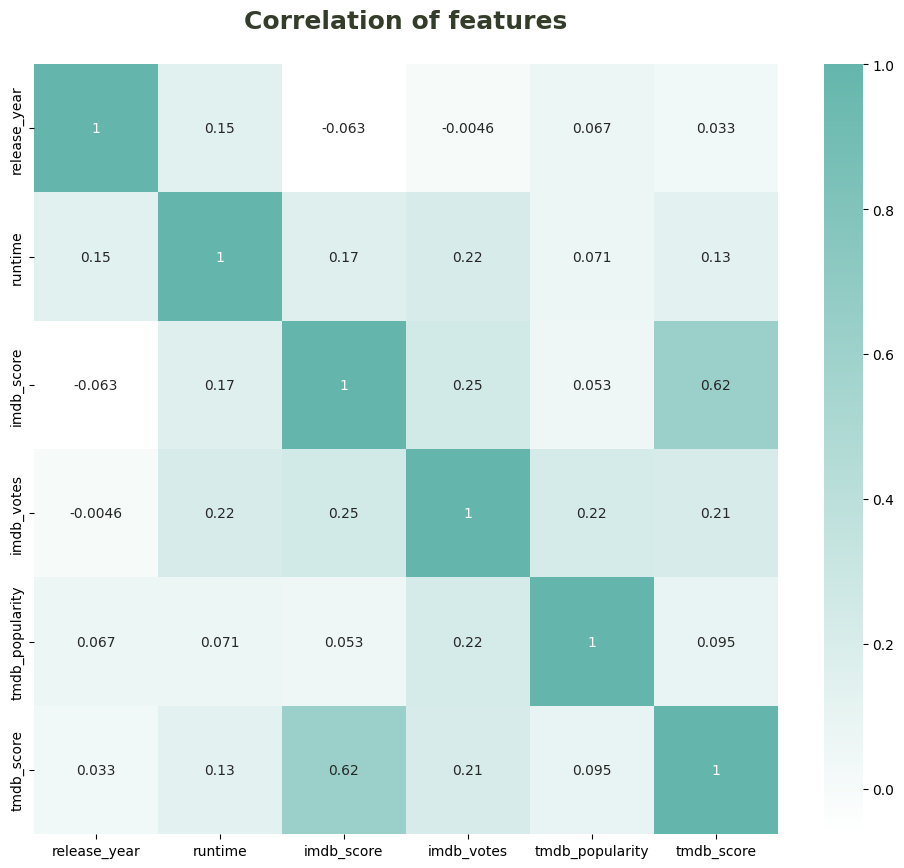

In [90]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_coolwarm', ['white', '#64b6ac'])
plt.figure(figsize=(12, 10))
plt.title('Correlation of features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(all_datasets.corr(), annot=True, cmap=cmap)
plt.show()

In [91]:
import pandas as pd

expanded_data = pd.DataFrame(columns=['Genre', 'IMDb_Score'])


rows_to_add = []

# Iterate over the original DataFrame
for index, row in all_datasets.iterrows():
    if pd.notnull(row['imdb_score']) and pd.notnull(row['genres']):
        for genre in row['genres'].split(', '):

            rows_to_add.append({'Genre': genre, 'IMDb_Score': row['imdb_score']})

# Convert the list of new rows to a DataFrame and concatenate it with the original DataFrame
expanded_data = pd.concat([expanded_data, pd.DataFrame(rows_to_add)], ignore_index=True)

# Convert IMDb_Score to numeric
expanded_data['IMDb_Score'] = pd.to_numeric(expanded_data['IMDb_Score'])


In [92]:
genre_list = []
for genres in all_datasets['genres']:
    if isinstance(genres, str):  # Check if the entry is a string
        genre_list.extend(genres.split(', '))


In [93]:
genre_df = pd.DataFrame(genre_list, columns=['genre'])

genre_counts = genre_df['genre'].value_counts()
top_10_genres = genre_counts.head(10)

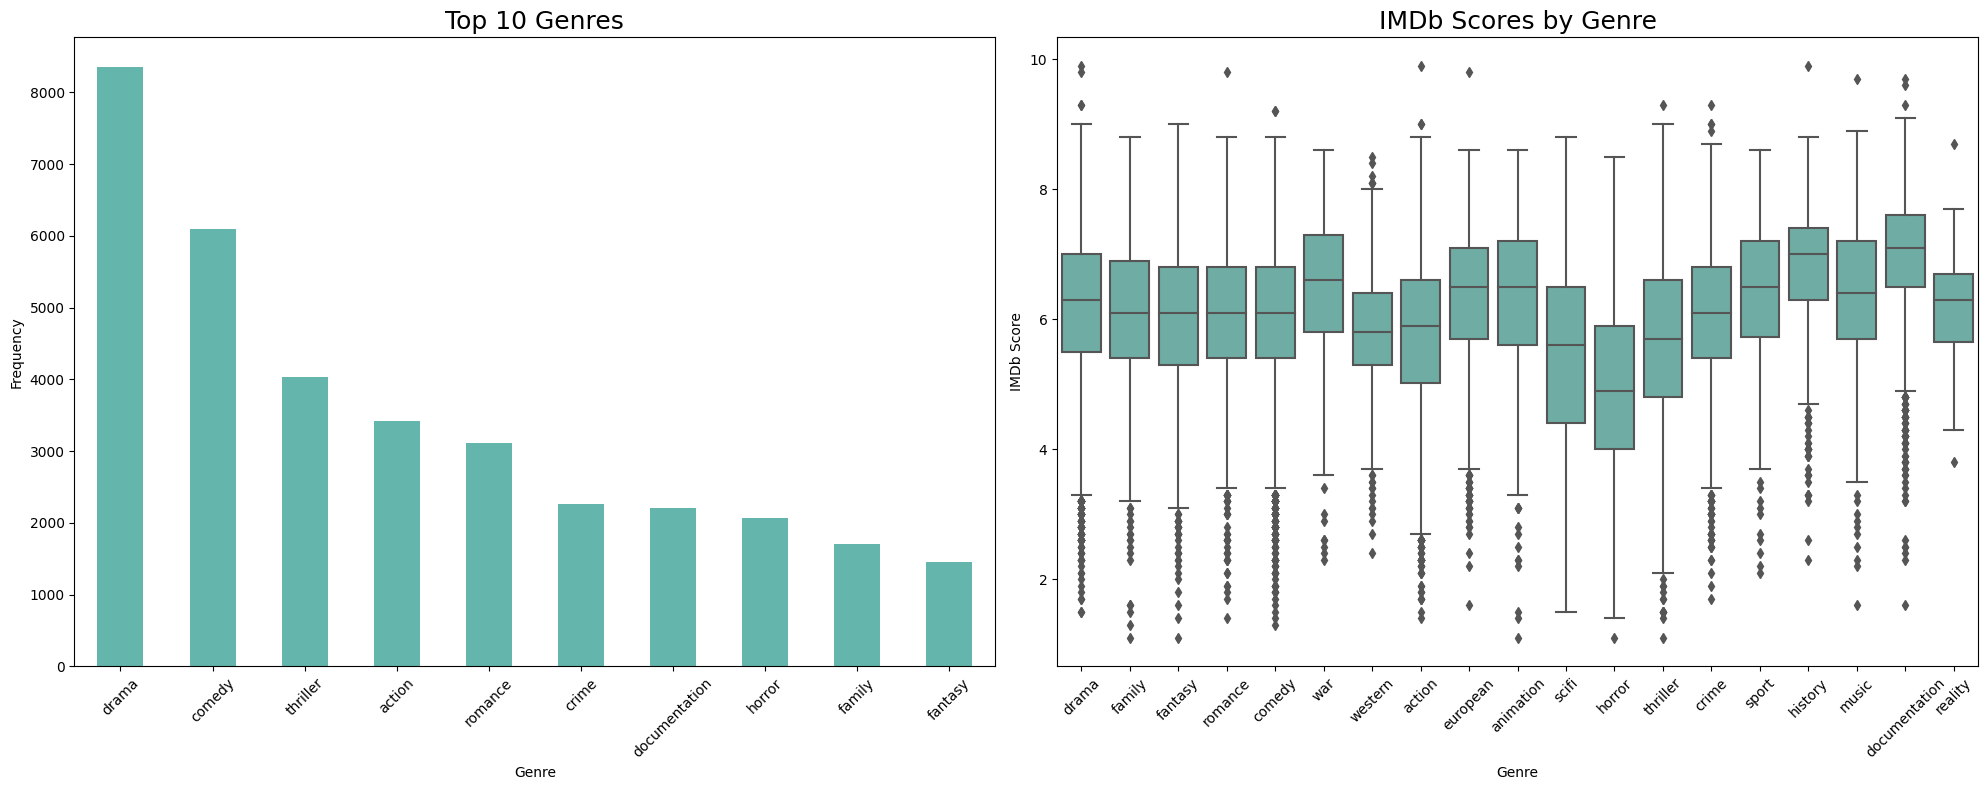

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


expanded_data_list = []


for index, row in all_datasets.iterrows():
    if pd.notnull(row['imdb_score']) and pd.notnull(row['genres']):
        for genre in row['genres'].split(', '):

            expanded_data_list.append({'Genre': genre, 'IMDb_Score': row['imdb_score']})


expanded_data = pd.DataFrame(expanded_data_list)


expanded_data['IMDb_Score'] = pd.to_numeric(expanded_data['IMDb_Score'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

top_10_genres.plot(kind='bar', color='#64b6ac', ax=ax1)
ax1.set_title('Top 10 Genres', fontsize=18)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

# Box plot for IMDb scores by genre
sns.boxplot(x='Genre', y='IMDb_Score', color ='#64b6ac', data=expanded_data, ax=ax2)
ax2.set_title('IMDb Scores by Genre', fontsize=18)
ax2.set_xlabel('Genre')
ax2.set_ylabel('IMDb Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust the layout
plt.show()

# 3.0 Recommendation system

**Helper functions**

In [95]:
# Install necessary packages in the background without printing output
! pip install python-Levenshtein > /dev/null 2>&1
! pip install tabulate > /dev/null 2>&1

# Import the Levenshtein module and tabulate function from their respective packages
import Levenshtein as lev
from tabulate import tabulate

# Define a function to find the closest movie title in the dataset based on a search query
def find_closest_title(search_query):
    best_match = None
    highest_similarity = 0

     # Compare the search query with each title in the dataset using Levenshtein ratio
    for title in all_datasets['title']:
        similarity = lev.ratio(search_query.lower(), title.lower())

        # Update the best match if a higher similarity score is found
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_match = title

    # Return the best matching title
    return all_datasets.loc[all_datasets['title'] == best_match]['title'].to_list()[0]

# Define a function to print movie recommendations in a tabular format
def print_recommendations(df):
    table = []
    i = 0
    for index, row in df.iterrows():
        i += 1
        table.append([f"{i}.", f"{row['title']}", f"{row['release_year']}", f"{row['platform']}", f"{row['similarity_score']}"])

    headers = ["#", "Title","Year" , "Platform", "Similarity score"]
    return tabulate(table, headers, tablefmt="simple")

def print_recommendations_cluster(df):
    table = []
    i = 0
    for index, row in df.iterrows():
        i += 1
        table.append([f"{i}.", f"{row['title']}", f"{row['release_year']}", f"{row['platform']}", f"{row['cluster']}"])

    headers = ["#", "Title","Year" , "Platform", "Cluster"]
    return tabulate(table, headers, tablefmt="simple")

def print_recommendations_rating_actors(df):
    table = []
    i = 0
    for index, row in df.iterrows():
        i += 1
        table.append([f"{i}.", f"{row['title']}", f"{row['release_year']}", f"{row['platform']}", f"{row['actors']}"])

    headers = ["#", "Title","Year" , "Platform", "Actors"]
    return tabulate(table, headers, tablefmt="simple")

def print_recommendations_hybrid(tfidf_df, embeddings_df, cluster_df, rating_and_actors_df):
    # Select top recommendations from different methods and label each recommendation with its respective method
    top_tfidf = tfidf_df.nlargest(5, 'similarity_score')
    top_tfidf['method'] = 'TF-IDF'
    top_embeddings = embeddings_df.nlargest(5, 'similarity_score')
    top_embeddings['method'] = 'Embeddings'
    top_rating_and_actors = rating_and_actors_df.head(5)
    top_rating_and_actors['method'] = 'Rating and actors'
    random_cluster = cluster_df.sample(5)
    random_cluster['method'] = 'Cluster'

    combined_df = pd.concat([top_tfidf, top_embeddings, random_cluster, top_rating_and_actors])

    table = []
    for _, row in combined_df.iterrows():
        table.append([row['title'], row['release_year'], row['platform'], row['method']])

    headers = ["Title", "Year", "Platform", "Method", "Similarity Score/Cluster"]
    return tabulate(table, headers, tablefmt="simple")




**Tfidf with cosine similarity**

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine relevant features into a single string to create a bag of words for each movie
all_datasets['bag_of_words'] = all_datasets[['title', 'genres', 'actors', 'directors', 'age_certification' ,'description']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Initialize a TF-IDF Vectorizer, ignoring English stop words
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')

# Fit the vectorizer to the bag of words data
tf.fit(all_datasets['bag_of_words'])

def get_recommendations_tdidf(title):
    # Find the index of the given movie title
    idx = all_datasets[all_datasets['title'] == title].index[0]
    # Transform the movie's bag of words into TF-IDF vector
    movie_tfidf = tf.transform([all_datasets['bag_of_words'].iloc[idx]])
    # Compute the cosine similarity between this movie's vector and all others
    cosine_sim = linear_kernel(movie_tfidf, tf.transform(all_datasets['bag_of_words']))
    # Get similarity scores for all movies and sort them
    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top 10 similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    # Retrieve these movies from the dataset
    recommendations = all_datasets.loc[movie_indices, ['title', 'release_year', 'platform']].copy()
    # Add similarity scores to the recommendations
    recommendations['similarity_score'] = [score[1] for score in sim_scores]
    return recommendations

title = "MATRIX"
title = find_closest_title(title)
print(f"Recommendations for '{title}'")
print(print_recommendations(get_recommendations_tdidf(title)))


Recommendations for 'The Matrix'
  #  Title                                    Year  Platform      Similarity score
---  -------------------------------------  ------  ----------  ------------------
  1  The Matrix Reloaded                      2003  hbo                  0.214511
  2  The Matrix Revolutions                   2003  hbo                  0.211527
  3  Bound                                    1996  paramount            0.142853
  4  The Matrix Resurrections                 2021  hbo                  0.137892
  5  Jack and Jill vs. The World              2010  amazon               0.0869647
  6  Martin Lawrence: You So Crazy            1994  hbo                  0.0771929
  7  A Zombie Croc: Evil Has Been Summoned    2015  darkmatter           0.0761244
  8  Doorways                                 1993  amazon               0.0755983
  9  Confessions of an Action Star            2009  amazon               0.0729898
 10  Tales from the Darkside: The Movie       1990  paramo

**Word embeddings with cosine similarity**

In [97]:
# Install the sentence-transformers package silently, without printing output
!pip install -U sentence-transformers > /dev/null 2>&1

from sentence_transformers import SentenceTransformer
# Initialize a SentenceTransformer model using 'paraphrase-distilroberta-base-v1'
# This model is designed for generating paraphrased sentence embeddings
sentence_transformer_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
# Generate embeddings for movie descriptions using the sentence transformer model
description = all_datasets['description'].tolist() # Convert all descriptions to a list
description_embeddings = [] # Initialize an empty list to store the embeddings

# Iterate over each description to generate its embedding
for i, des in enumerate(description):
    if i % 1000 == 0:
      print(i)
    description_embeddings.append(sentence_transformer_model.encode(des))

# Save the generated embeddings to a file for future use
np.save("description_embeddings.npy", np.array(description_embeddings))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [98]:
from sklearn.metrics.pairwise import linear_kernel
#embeddings = np.load("description_embeddings.npy")

# Load precomputed embeddings for movie descriptions from a specified path
embeddings = np.load(drive_path + "data/embeddings/description_embeddings.npy")

from sentence_transformers import SentenceTransformer, util

def get_recommendations_embeddings(title):
    # Retrieve the description of the specified movie and generate its embedding
    description = all_datasets.loc[all_datasets['title'] == title]['description'].to_list()[0]
    description_embedded = sentence_transformer_model.encode(description)
    # Reshape the embedding for compatibility with linear_kernel
    description_embedded = description_embedded.reshape(1, -1)
    # Calculate the cosine similarity between this embedding and all others
    cosine_sim = linear_kernel(description_embedded, embeddings)
    sim_scores = list(enumerate(cosine_sim[0]))
     # Sort the movies based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top 10 similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    # Retrieve these movies from the dataset
    recommendations = all_datasets.loc[movie_indices, ['title', 'release_year', 'platform']].copy()
    # Add similarity scores to the recommendations
    recommendations['similarity_score'] = [score[1] for score in sim_scores]
    return recommendations

title = "MATRIX"
title = find_closest_title(title)
print(f"Recommendations for '{title}'")
print(print_recommendations(get_recommendations_embeddings(title)))

Recommendations for 'The Matrix'
  #  Title                              Year  Platform      Similarity score
---  -------------------------------  ------  ----------  ------------------
  1  Bigbug                             2022  netflix                27.3926
  2  The Matrix Reloaded                2003  hbo                    25.0328
  3  Ninja Apocalypse                   2014  amazon                 24.028
  4  The Terminator                     1984  hbo                    23.7966
  5  Transformers: Age of Extinction    2014  amazon                 23.7308
  6  Dexter's Laboratory: Ego Trip      1999  amazon                 23.363
  7  Evangelion: Death (True)²          1998  netflix                23.342
  8  Jackrabbit                         2016  amazon                 22.0328
  9  Night Raiders                      2021  hulu                   21.5441
 10  The Matrix Revolutions             2003  hbo                    21.5391


**Kmeans clustering**

In [99]:
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

clustering_dataset = all_datasets.copy()
clustering_dataset['genres'] = clustering_dataset['genres'].str.split(', ')

# Process 'genres' column by splitting strings and creating a set of unique genres
unique_genres = set(genre for sublist in clustering_dataset['genres'].dropna() for genre in sublist)

# Initialize columns for each genre with 0
for genre in unique_genres:
    clustering_dataset[genre] = 0

# Assign 1 to relevant genre columns for each movie
for index, row in clustering_dataset.iterrows():
    if row['genres'] is not None:
      for genre in row['genres']:
          clustering_dataset.at[index, genre] = 1

# Drop rows with missing production countries
clustering_dataset = clustering_dataset.dropna(subset=['production_countries'])

# Clean 'production_countries' by removing brackets and quotes
clustering_dataset['production_countries'] = clustering_dataset['production_countries'].str.replace('\[', '', regex=True)
clustering_dataset['production_countries'] = clustering_dataset['production_countries'].str.replace('\]', '', regex=True)
clustering_dataset['production_countries'] = clustering_dataset['production_countries'].str.replace("'", '', regex=True)
clustering_dataset['production_countries'] = clustering_dataset['production_countries'].str.split(', ')

# Create a set of unique production countries
unique_production_countries = set(production_country for sublist in clustering_dataset['production_countries'].dropna() for production_country in sublist)

# Initialize columns for each production country with 0
for production_country in unique_production_countries:
    clustering_dataset[production_country] = 0

# Assign 1 to relevant production country columns for each movie
for index, row in clustering_dataset.iterrows():
    if row['production_countries'] is not None:
      for production_country in row['production_countries']:
          clustering_dataset.at[index, production_country] = 1

# Drop columns that are not needed for clustering
columns_to_drop = [
    'tmdb_score',
    'imdb_id',
    'id',
    'type',
    'age_certification',
    'description',
    'title',
    'production_countries',
    'genres',
    'actors',
    'directors',
    'platform',
    'bag_of_words'
]

clustering_dataset = clustering_dataset.drop(columns_to_drop, axis=1)

# Fill missing data with column means
means = clustering_dataset.mean()
clustering_dataset = clustering_dataset.fillna(means)

# Scale features to range [0, 1]
scaler = MinMaxScaler()
clustering_dataset_scaled = scaler.fit_transform(clustering_dataset)
clustering_dataset_scaled = pd.DataFrame(clustering_dataset_scaled, columns=clustering_dataset.columns)

# Reduce dimensions of the dataset using PCA
pca = PCA(n_components=80)
clustering_dataset_scaled_pca = pd.DataFrame(pca.fit(clustering_dataset_scaled).transform(clustering_dataset_scaled))

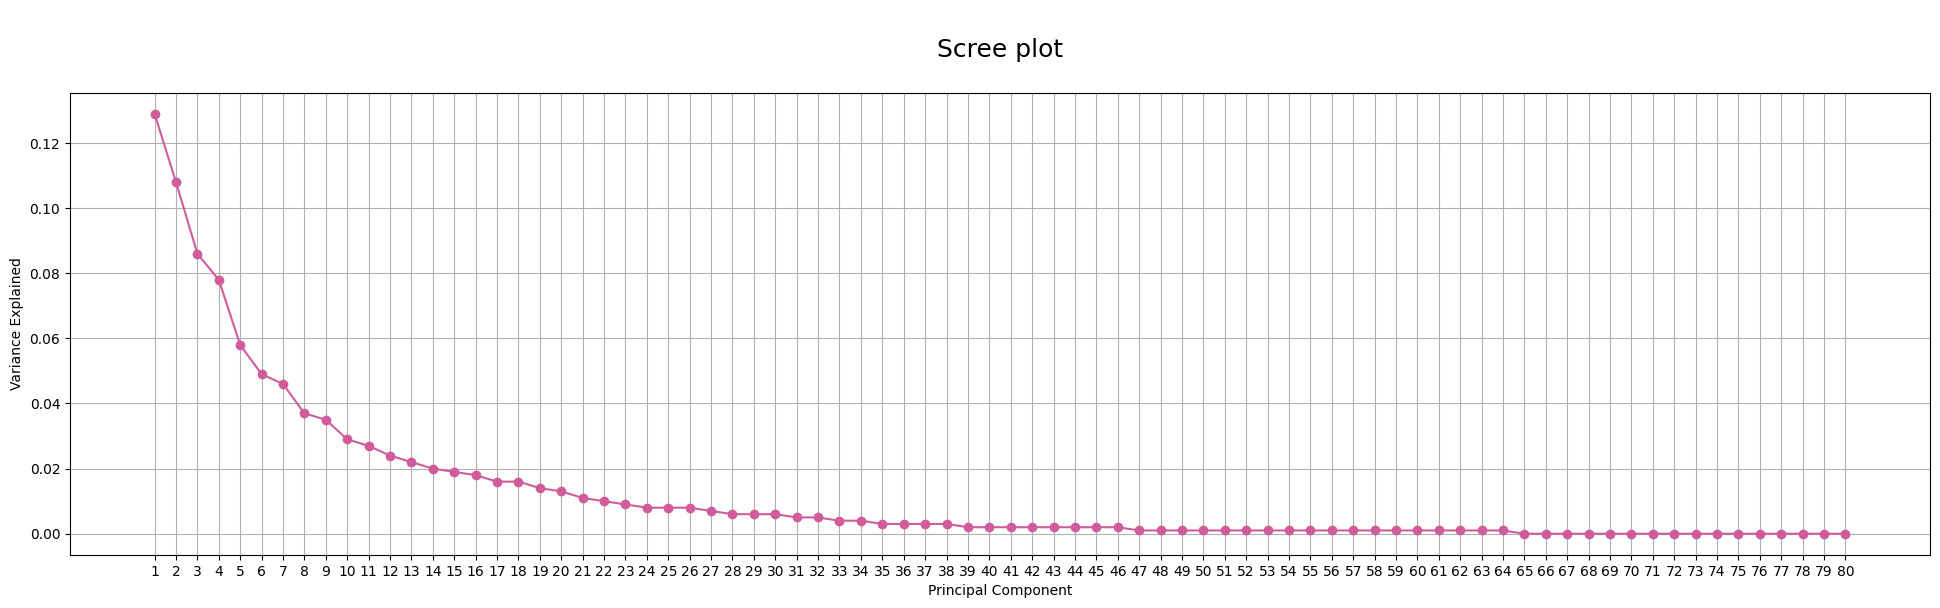

In [100]:
# This code creates a Scree plot to visualize the proportion of variance explained by each of the first 80 principal components from PCA, aiding in the decision of how many components to retain based on their contribution to total variance.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = np.round(explained_variance_ratio, 3)

plt.figure(figsize=(24,6))
plt.title('\nScree plot\n', fontsize=18)
plt.plot(np.arange(1, 81), explained_variance, marker='o', color='#D05C9C')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, 81))
plt.grid(True)
plt.show()


In [101]:
# Initialize PCA with 10 components and transform the scaled clustering dataset, reducing its dimensionality for more efficient clustering analysis.
pca = PCA(n_components=10)
clustering_dataset_scaled_pca = pd.DataFrame(pca.fit(clustering_dataset_scaled).transform(clustering_dataset_scaled))

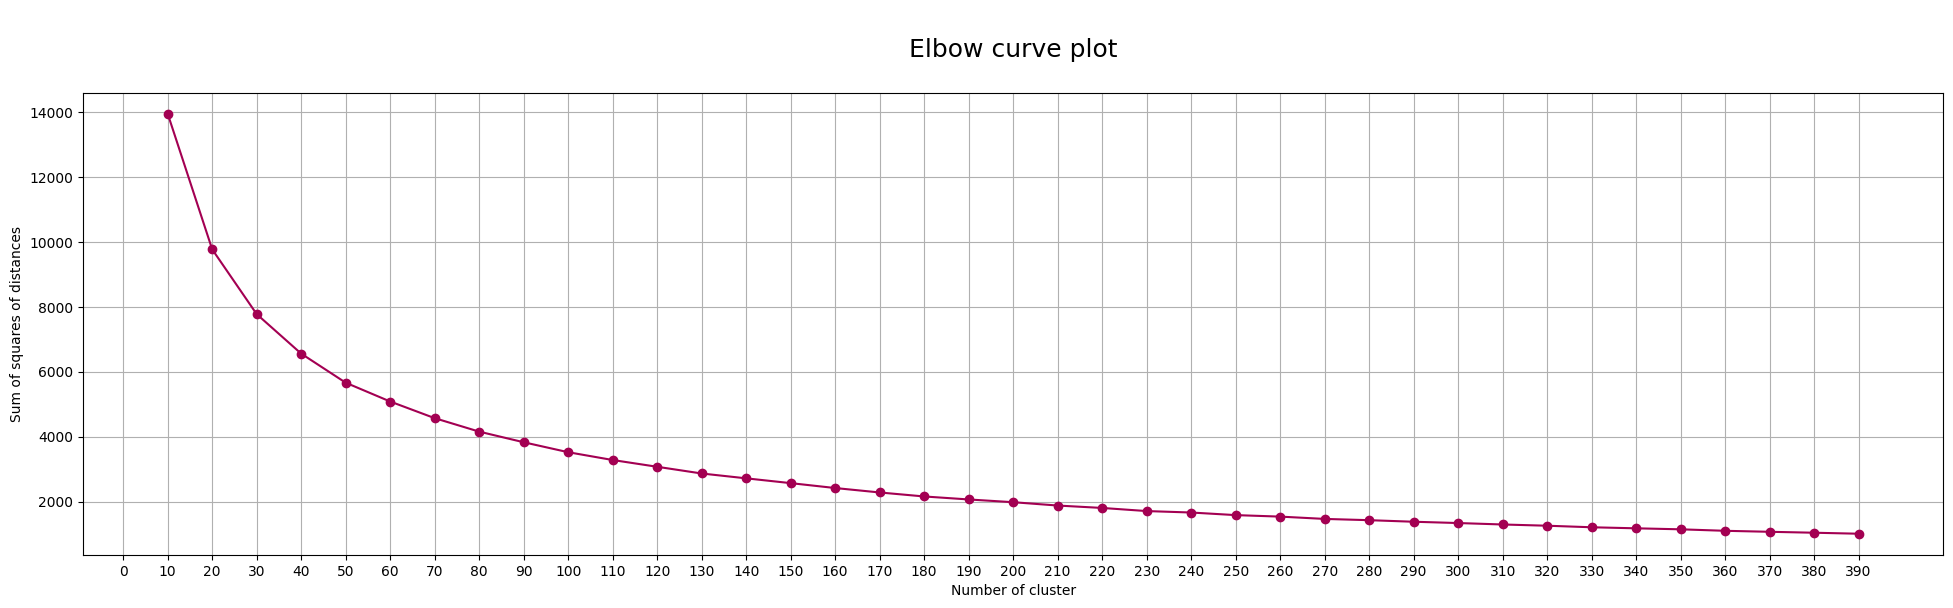

In [104]:
# This code runs K-Means clustering with varying cluster numbers (10 to 390 in steps of 10), stores each model and its inertia (sum of squared distances to the nearest cluster center), and then plots these values to create an Elbow curve, assisting in the optimal cluster number selection.

models = []
dist = []

for k in range(10, 400, 10):
    model = KMeans(n_clusters=k, random_state=8, max_iter=10000)
    model.fit(clustering_dataset_scaled_pca)
    models.append(model)
    dist.append(model.inertia_)

plt.figure(figsize=(24,6))
plt.title('\nElbow curve plot\n', fontsize=18)
plt.plot(np.arange(10, 400,10), dist, marker='o', color='#a30052')
plt.xlabel('Number of cluster')
plt.ylabel('Sum of squares of distances')
plt.xticks(np.arange(0, 400,10))
plt.grid(True)
plt.show()

In [105]:
# Set the number of clusters for KMeans. This is sat with regard to the elbow plot but also with experimenting with the output and silhoutte score
k = 350
clusterer = KMeans(n_clusters=k, random_state=42)
cluster_labels = clusterer.fit_predict(clustering_dataset_scaled_pca)

all_datasets['cluster'] = cluster_labels

silhouette_avg = silhouette_score(clustering_dataset_scaled_pca, cluster_labels)

print("Silhouette score:", silhouette_avg)
print("Number of clusters:", len(set(cluster_labels)))
print("")

def get_recommendations_kmeans(title):
    # Find the index of the given title in the dataset
    idx = all_datasets[all_datasets['title'] == title].index[0]
    # Retrieve the cluster number of the given title
    cluster_value = all_datasets.at[idx, 'cluster']
    # Find all items in the same cluster
    same_cluster = all_datasets[all_datasets['cluster'] == cluster_value]
    # Randomly select 10 items from the same cluster as recommendations
    recommendations = same_cluster.sample(n=10)
    return recommendations

title = "MATRIX"
title = find_closest_title(title)
print(f"Recommendations for '{title}'")
print(print_recommendations_cluster(get_recommendations_kmeans(title)))

Silhouette score: 0.664157835953095
Number of clusters: 350

Recommendations for 'The Matrix'
  #  Title                              Year  Platform      Cluster
---  -------------------------------  ------  ----------  ---------
  1  Transformers: Dark of the Moon     2011  netflix           233
  2  Lake Alice                         2018  darkmatter        233
  3  Escape from New York               1981  amazon            233
  4  Cold Zone                          2017  amazon            233
  5  Ape vs. Monster                    2021  amazon            233
  6  Star Trek Into Darkness            2013  paramount         233
  7  The Matrix                         1999  hbo               233
  8  Transformers: Age of Extinction    2014  amazon            233
  9  Edge of Tomorrow                   2014  hbo               233
 10  Logan's Run                        1976  hbo               233


**Method based on rating and common actors vizualised with social graphs**

  #  Title                              Year  Platform    Actors
---  -------------------------------  ------  ----------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

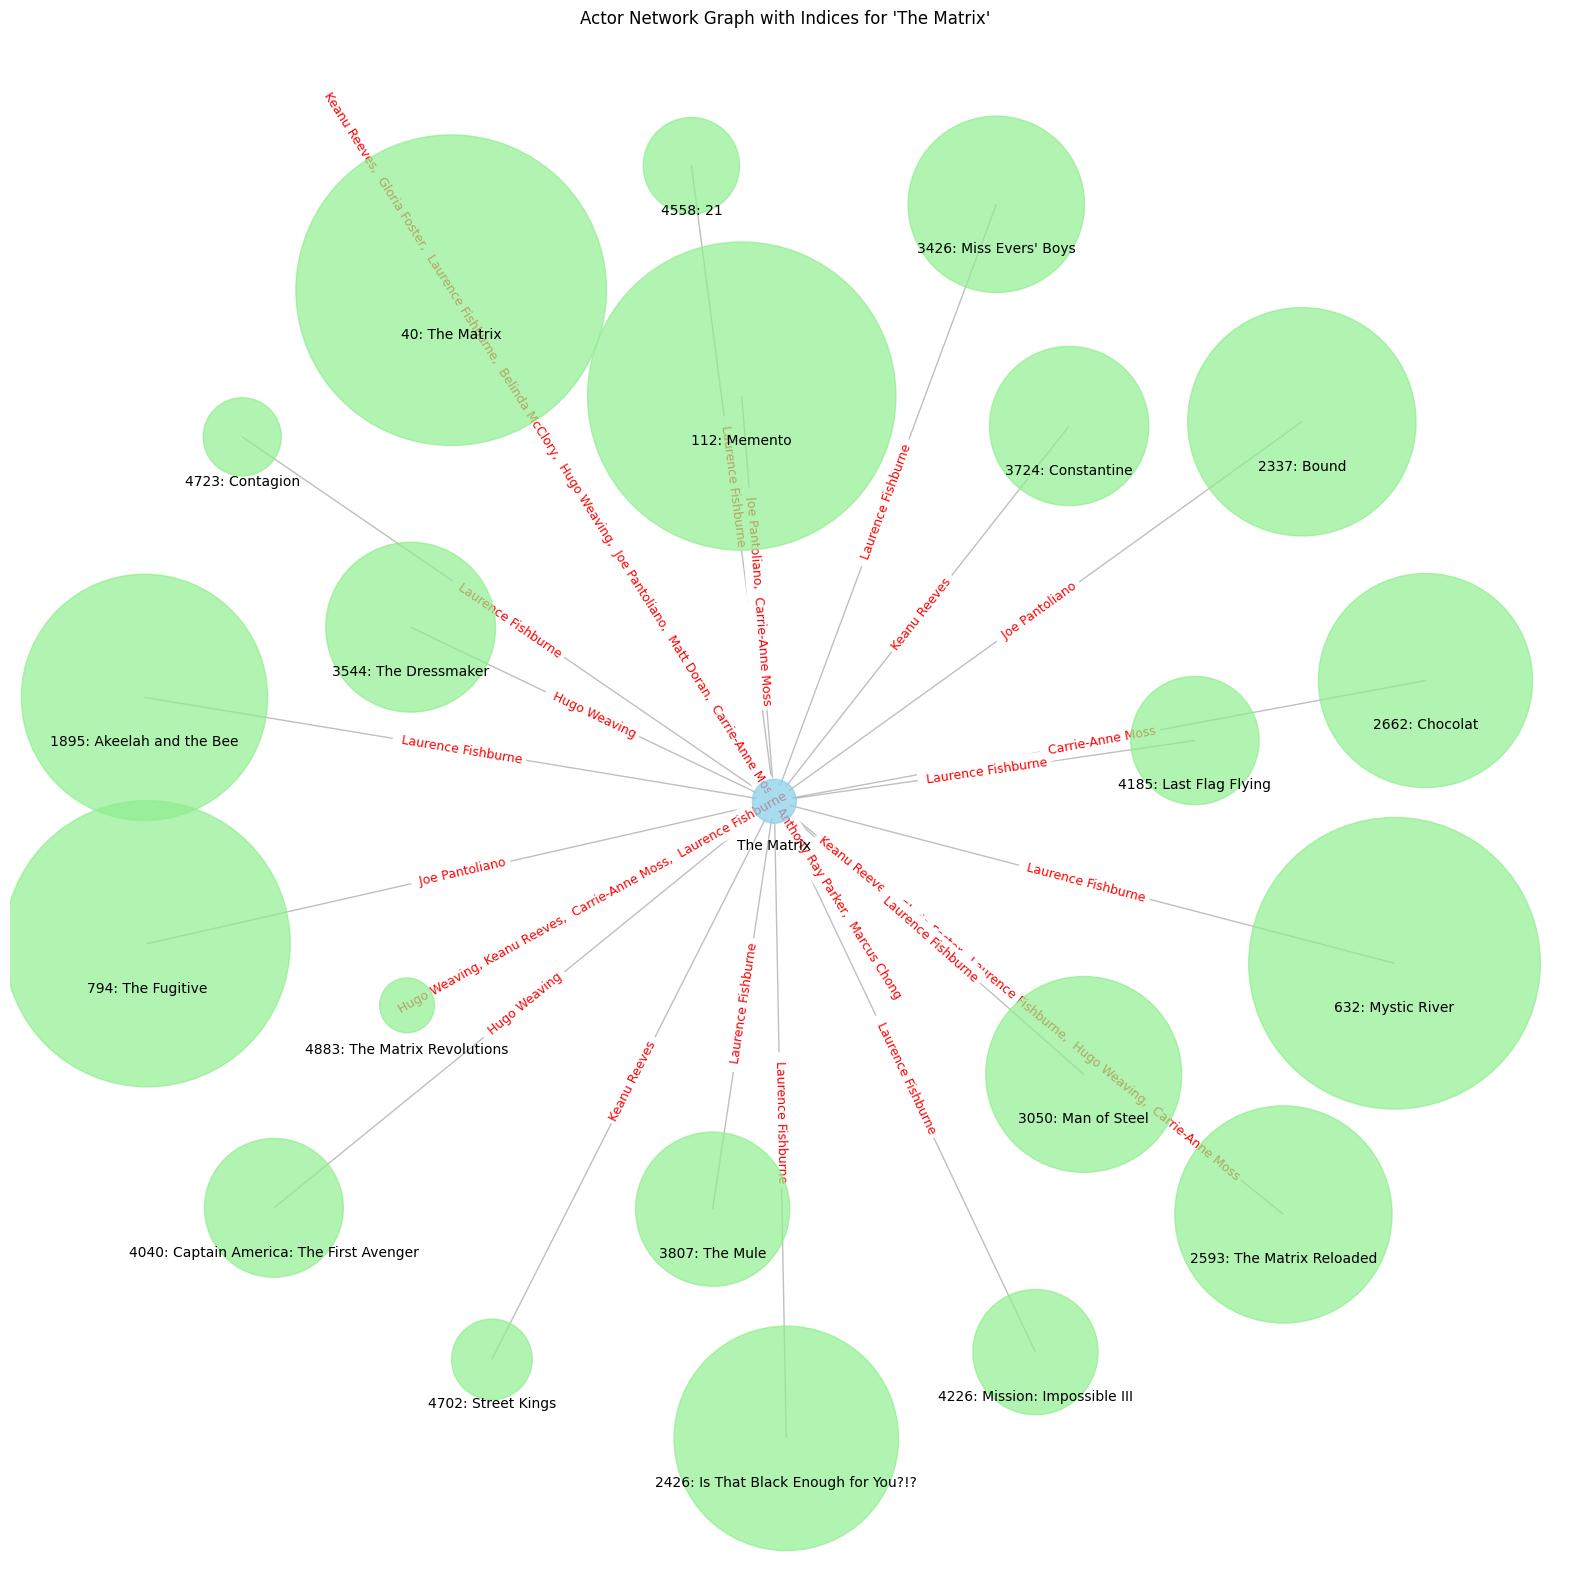

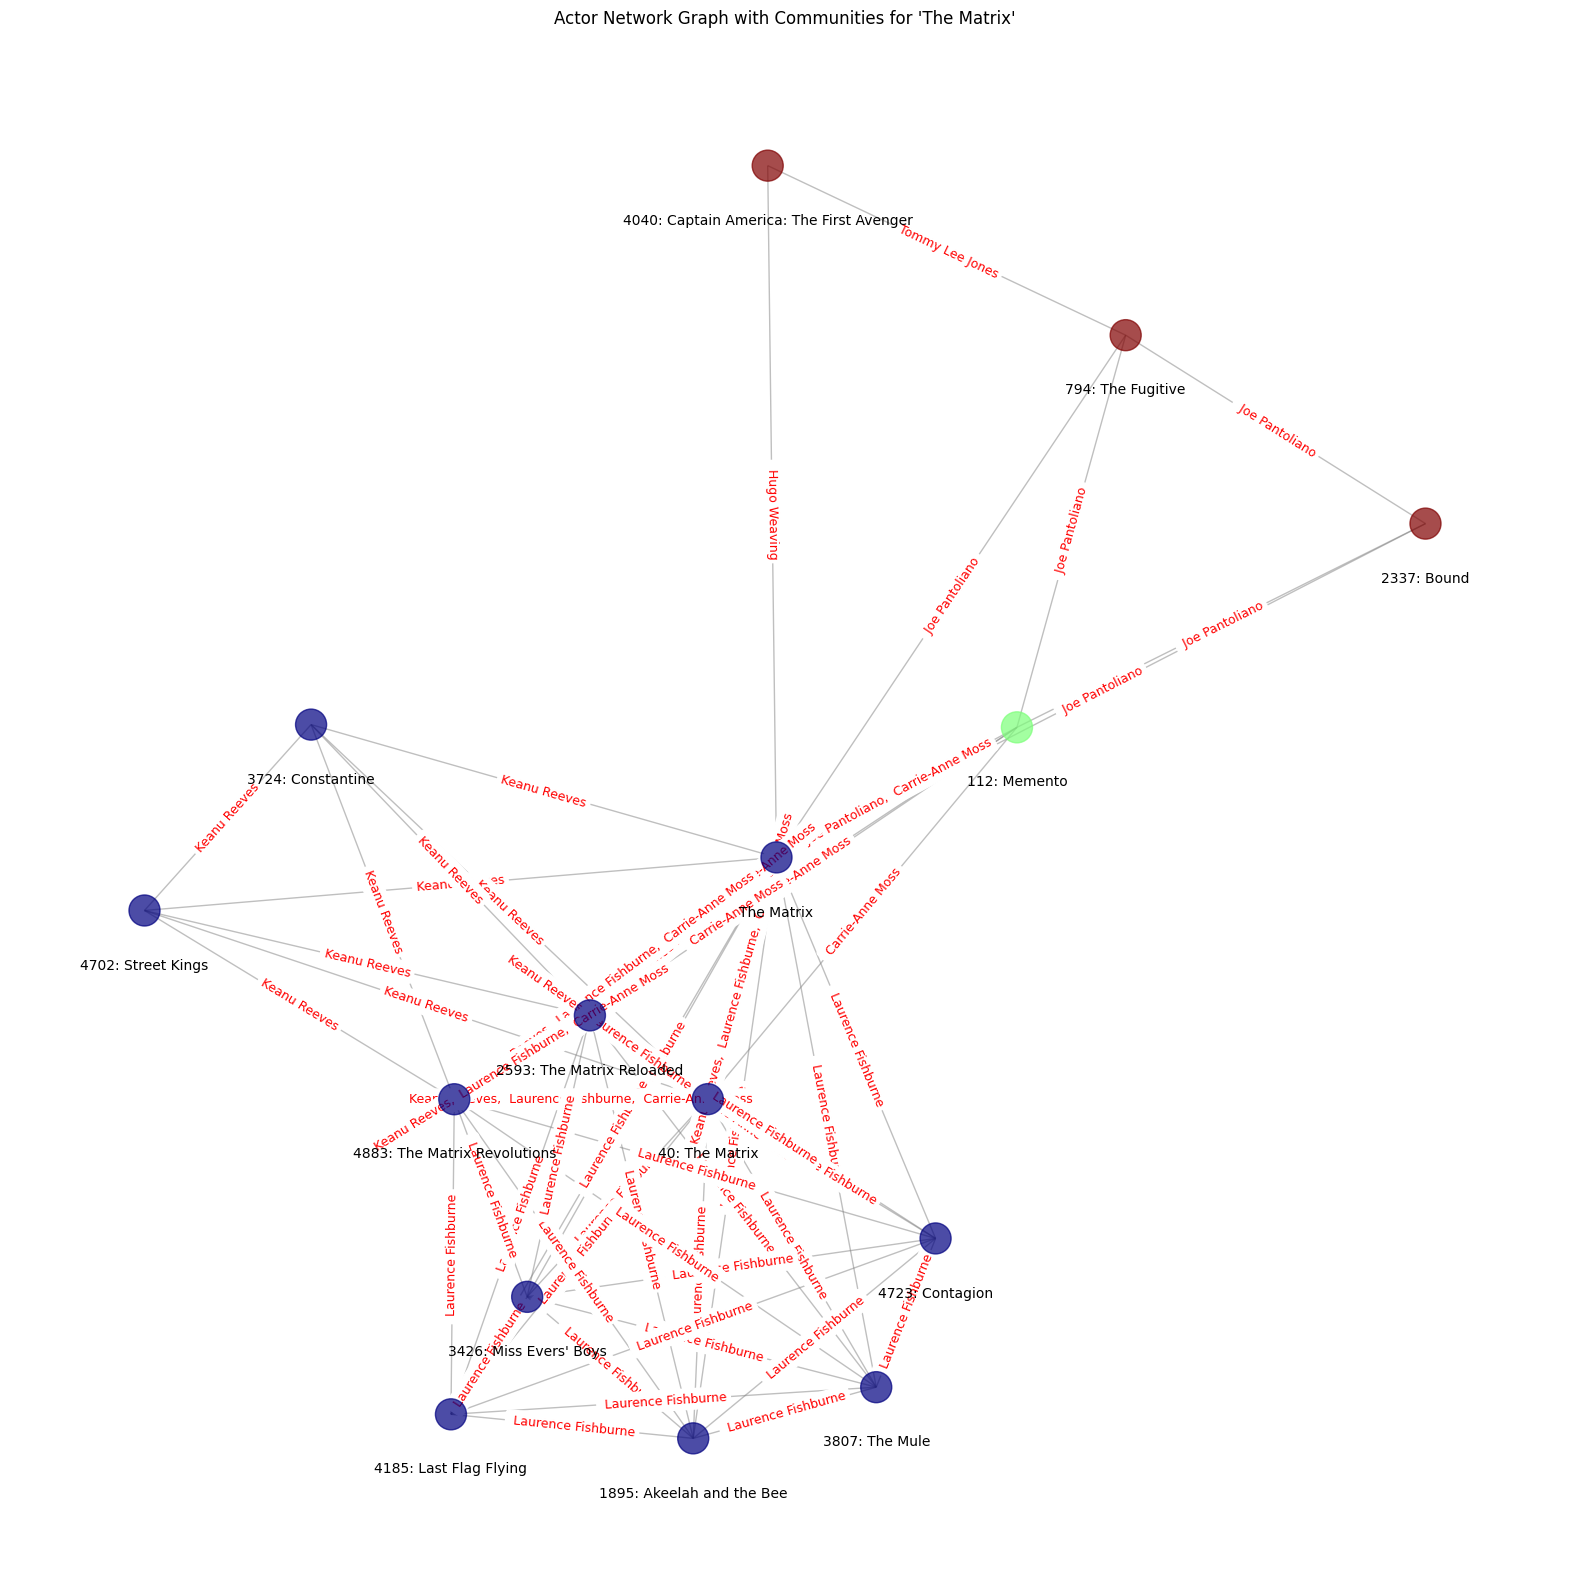

In [115]:
import networkx as nx
from networkx.algorithms import community

# Preparing a dataset of top-rated movies
top_rated_movies = all_datasets.sort_values(by='imdb_score', ascending=False).head(5000)

def get_recommendations_rating_and_actors(title, top_rated_movies):
    movie_indices = []
    top_rated_movies = top_rated_movies.reset_index(drop=True)

     # Extracting actors from the input movie
    input_movie_actors = set(all_datasets[all_datasets['title'] == title]['actors'].iloc[0].split(',')[:10])

    input_index = all_datasets[all_datasets['title'] == title].index[0]

    # Looping through top-rated movies to find movies with shared actors
    for index, row in top_rated_movies.iterrows():
        movie_actors = set(row['actors'].split(',')[:10])
        shared_actors = input_movie_actors.intersection(movie_actors)
        if shared_actors:
            movie_indices.append(index)

    # Creating a DataFrame of recommended movies
    recommendations = top_rated_movies.loc[movie_indices, ['title', 'release_year', 'platform', 'actors']].copy()[:10]

    return recommendations

def create_actor_network_graph_with_indices(input_title, top_rated_movies, all_datasets):
    top_rated_movies = top_rated_movies.reset_index(drop=True)
    G = nx.Graph()  # Initializing a Graph
    input_movie_actors = set(all_datasets[all_datasets['title'] == input_title]['actors'].iloc[0].split(',')[:10])

    input_index = all_datasets[all_datasets['title'] == input_title].index[0]

    # Adding the input movie as a node in the graph
    G.add_node(input_index, title=input_title, main=True, actors=input_movie_actors)

    max_index = top_rated_movies.index.max()
    node_sizes = {input_index: 1000} # Setting size for the input movie node

    # Looping through recommendations to add them as nodes and edges to the graph
    for index, row in top_rated_movies.iterrows():
        movie_actors = set(row['actors'].split(',')[:10])
        shared_actors = input_movie_actors.intersection(movie_actors)
        if shared_actors:
            movie_index = index
            movie_title = row['title']
            # Adding each movie as a node and creating edges based on shared actors
            G.add_node(movie_index, title=movie_title, actors=movie_actors)
            G.add_edge(input_index, movie_index, label=', '.join(shared_actors))
            node_sizes[movie_index] = 400 + (max_index - index) * 10

    # Setting up positions for nodes in the graph
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    # Drawing the graph
    plt.figure(figsize=(20, 20))
    color_map = ['skyblue' if 'main' in G.nodes[node] else 'lightgreen' for node in G]
    nx.draw_networkx_nodes(G, pos, node_size=[node_sizes[node] for node in G], node_color=color_map, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')

    # Adding labels to nodes
    node_labels = {node: (f"{node}: " if node != input_index else '') + data['title'] for node, data in G.nodes(data=True)}
    label_pos = {k: [v[0], v[1] - 0.07] for k, v in pos.items()}
    nx.draw_networkx_labels(G, label_pos, labels=node_labels, font_size=10)

    # Adding labels to edges
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

    # Final touches to the plot
    plt.title(f"Actor Network Graph with Indices for '{input_title}'")
    plt.axis('off')
    plt.show()


def create_actor_network_graph_with_indices2(input_title, top_rated_movies, all_datasets):
    top_rated_movies = top_rated_movies.reset_index(drop=True)
    G = nx.Graph() # Initializing a Graph

    # Extracting actors from the input movie
    input_movie_actors = set(all_datasets[all_datasets['title'] == input_title]['actors'].iloc[0].split(',')[:10])
    input_index = all_datasets[all_datasets['title'] == input_title].index[0]

    # Adding the input movie as a node in the graph
    G.add_node(input_index, title=input_title, main=True, actors=input_movie_actors)

    # Adding nodes and edges for recommended movies
    for index, row in top_rated_movies.iterrows():
        movie_actors = set(row['actors'].split(',')[:3])
        shared_actors = input_movie_actors.intersection(movie_actors)
        if shared_actors:
            movie_index = index
            movie_title = row['title']
            G.add_node(movie_index, title=movie_title, actors=movie_actors)
            G.add_edge(input_index, movie_index, label=', '.join(shared_actors))

    # Adding edges between movies based on shared actors
    for node1, attrs1 in G.nodes(data=True):
        if node1 == input_index:
            continue
        for node2, attrs2 in G.nodes(data=True):
            if node2 == input_index or node1 == node2:
                continue
            shared_actors = attrs1['actors'].intersection(attrs2['actors'])
            if shared_actors:
                G.add_edge(node1, node2, label=', '.join(shared_actors))

    # Identifying communities within the graph
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    communities = sorted(map(sorted, next_level_communities))

    # Setting up positions for nodes in the graph
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    plt.figure(figsize=(20, 20))

    # Setting up colors for different communities
    color_map = []
    for node in G:
        for idx, comm in enumerate(communities):
            if node in comm:
                color_map.append(idx)
                break
        else:
            color_map.append(len(communities))

    # Adding labels, nodes, and edges to the graph
    node_labels = {node: (f"{node}: " if node != input_index else '') + data['title'] for node, data in G.nodes(data=True)}
    label_pos = {k: [v[0], v[1] - 0.07] for k, v in pos.items()}
    nx.draw_networkx_labels(G, label_pos, labels=node_labels, font_size=10)

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=color_map, cmap=plt.cm.jet, alpha=0.7)

    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

    # Final touches to the plot
    plt.title(f"Actor Network Graph with Communities for '{input_title}'")
    plt.axis('off')
    plt.show()
    return G





title = "MATRIX"
title = find_closest_title(title)
print(print_recommendations_rating_actors(get_recommendations_rating_and_actors(title, top_rated_movies)))
create_actor_network_graph_with_indices(title, top_rated_movies, all_datasets)
create_actor_network_graph_with_indices2(title, top_rated_movies, all_datasets)

**Hybrid**

In [107]:
def get_recommendations_hybrid(title):
  tfidf_recommendations = get_recommendations_tdidf(title)
  rating_and_actors_recommendations = get_recommendations_rating_and_actors(title, top_rated_movies)
  embeddings_recommendations = get_recommendations_embeddings(title)
  kmeans_recommendations = get_recommendations_kmeans(title)

  # Return all different types of recommendations
  return tfidf_recommendations, embeddings_recommendations, kmeans_recommendations, rating_and_actors_recommendations


title = "MATRIX"
title = find_closest_title(title)
print(f"Recommendations for '{title}'")
tfidf_recommendations, embeddings_recommendations, kmeans_recommendations, rating_and_actors_recommendations = get_recommendations_hybrid(title)
print(print_recommendations_hybrid(tfidf_recommendations, embeddings_recommendations, kmeans_recommendations, rating_and_actors_recommendations))

Recommendations for 'The Matrix'
Title                              Year  Platform    Method
-------------------------------  ------  ----------  -----------------
The Matrix Reloaded                2003  hbo         TF-IDF
The Matrix Revolutions             2003  hbo         TF-IDF
Bound                              1996  paramount   TF-IDF
The Matrix Resurrections           2021  hbo         TF-IDF
Jack and Jill vs. The World        2010  amazon      TF-IDF
Bigbug                             2022  netflix     Embeddings
The Matrix Reloaded                2003  hbo         Embeddings
Ninja Apocalypse                   2014  amazon      Embeddings
The Terminator                     1984  hbo         Embeddings
Transformers: Age of Extinction    2014  amazon      Embeddings
Squadron of Doom                   1949  amazon      Cluster
Transformers: Age of Extinction    2014  amazon      Cluster
Tremors: Shrieker Island           2020  netflix     Cluster
Dark Phoenix                     